<a href="https://colab.research.google.com/github/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Twitter_Sentiment_Analysis_Model_With_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PySastrawi==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 2.6 MB/s eta 0:00:00


In [2]:
# Mengimpor library untuk preprocessing data
import pandas as pd
import numpy as np
import string
import nltk
import pickle
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for word embedding and model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# for evaluation on test data
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#Membuat fungsi load_data untuk membuka file csv hasil crawling data
url= "https://github.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Dataset/Data-hasil-klasifikasi-positif-negatif.xlsx?raw=true"

In [4]:
df = pd.read_excel(url)
df.sample(10)

,tweetcreatedts,username,text,source,tweet_clean,tweet_english,klasifikasi
560,25/02/2023 10:30,SeputariNews,menanggapi vonis chuckputranto masih pertimban...,TweetDeck,menanggapi vonis chuckputranto masih pertimban...,"responding to chuckputranto's verdict, still c...",Negatif
934,27/02/2023 02:38,Lusionari,anies manusia munafik aniesbaswedan aniesdiduk...,SocialPilot.co,anies manusia munafik aniesbaswedan aniesdiduk...,anies human hypocrites aniesbaswedan aniesdidu...,Negatif
1172,24/02/2023 09:54,DrSukamta,pks siap menang dan menangkan anies baswedan p...,Twitter for iPhone,pks siap menang dan menangkan anies baswedan p...,pks ready to win and win anies baswedan pks pa...,Positif
34,27/02/2023 11:37,SampaiJauhcom,mengenal diffuse axonal injury yang dialami da...,FS POSTER - Twitter App,mengenal diffuse axonal injury yang dialami da...,get to know the diffuse axonal injury experien...,Positif
14,27/02/2023 14:23,Lintas_MNCTV,komisi pemberantasan korupsi kpk akan mengklar...,Twitter Web App,komisi pemberantasan korupsi kpk akan mengklar...,the kpk corruption eradication commission will...,Positif
1013,26/02/2023 05:01,AsepSeptiyana_,waadduuhh parah bgt si ini anies aniesbaswedan...,Twitter for Android,waadduuhh parah bgt si ini anies aniesbaswedan...,waadduuhh by bgt si this anies aniesbaswedan d...,Negatif
1,27/02/2023 23:47,YukToleran,psikolog forensik nilai sikap brutal mds yg la...,Twitter for Android,psikolog forensik nilai sikap brutal mds yg la...,forensic psychologist the value of mds brutal ...,Negatif
334,25/02/2023 12:15,rayjgirl87,surat surat terbuka dari sekolah universitas d...,Twitter Web App,surat surat terbuka dari sekolah universitas d...,letter of open letter from the university scho...,Negatif
974,26/02/2023 08:48,OfficialBMI__,sikap bersama bmi mendukung anies ahy menjadi ...,Twitter for Android,sikap bersama bmi mendukung anies ahy menjadi ...,the attitude of bmi supports anies ahy to beco...,Negatif
332,25/02/2023 12:17,rayjgirl87,sore sore nyelot dl lahh agnesgracia mariodand...,Twitter Web App,sore sore nyelot dl lahh agnesgracia mariodand...,afternoon driving dl lahah agnesgady mariodand...,Negatif


In [5]:
#Menampilkan berapa banyak baris dan kolom
df.shape 

(1258, 7)

In [6]:
#Menampilkan daftar kolom, jumlah null, dan tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweetcreatedts  1258 non-null   object
 1   username        1258 non-null   object
 2   text            1258 non-null   object
 3   source          1258 non-null   object
 4   tweet_clean     1258 non-null   object
 5   tweet_english   1258 non-null   object
 6   klasifikasi     1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


In [7]:
# calculating missingess of entire DF
missingness = df.isnull().sum().sum() / df.count().sum()
print('Overall Missingness of df is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df).head(10)

Overall Missingness of df is: 0.00%


,Total,Percent
tweetcreatedts,0,0.0
username,0,0.0
text,0,0.0
source,0,0.0
tweet_clean,0,0.0
tweet_english,0,0.0
klasifikasi,0,0.0


In [8]:
#Hapus baris yang memiliki nilai null
df.dropna(inplace=True)

In [9]:
#Lihat duplikat data
duplCheck = df.duplicated().sum()
duplCheck

9

In [10]:
#Remove duplicate
df = df.reset_index(drop=True).drop_duplicates(subset='text', keep="last", ignore_index=True)

In [11]:
#Mneghitung jumlah source
df["source"].value_counts()

Twitter for Android        516
Twitter Web App            474
Twitter for iPhone          58
FAJAR.CO.ID                 32
TweetDeck                   32
dlvr.it                     23
corong nusantara            18
SocialPilot.co              15
twittbot.net                14
Twitter Media Studio        12
FS Poster 3                  9
JPNN News Update             8
IFTTT                        8
ms-room.com                  7
Jetpack.com                  4
Buffer                       4
Instagram                    4
genpico                      3
VOI.ID                       2
Ceklissatu Apps              2
LaterMedia                   1
Twitter for iPad             1
FS POSTER - Twitter App      1
SocialChamp IO               1
Name: source, dtype: int64

In [12]:
#Mneghitung jumlah klasifikasi
df["klasifikasi"].value_counts()

Negatif    747
Positif    502
Name: klasifikasi, dtype: int64

In [13]:
#Membuat datagrame baru yang terdiri dari kolom tweet dan klasifikasi saja
data = pd.DataFrame(df[['text', 'klasifikasi']])

### Case Folding, Menghilangkan tanda baca dan karakter yang tidak diperlukan

In [14]:
# Menghilangkan tanda baca dan karakter yang tidak diperlukan
def case_folding(Tweets):
      #Menggabungkan karakter pada tweet
      Tweets = "".join([char for char in Tweets if char not in string.punctuation])
      #Removing hashtags and mentions
      Tweets = re.sub("@[A-Za-z0-9_]+","", Tweets)
      Tweets = re.sub("#[A-Za-z0-9_]+","", Tweets)
      #Menghilangkan angka
      Tweets = re.sub(r'[-+]?[0-9]+', '', Tweets)  
      #Menghilangkan url web
      Tweets = re.sub(r'https?://\S+|www\.\S+', '', Tweets)
      #Menghapus tanda baca
      Tweets = re.sub(r'[^\w\s]', '', Tweets)   
      Tweets = re.sub('[()!?]', ' ', Tweets)
      Tweets = re.sub('\[.*?\]',' ', Tweets)              
      Tweets = Tweets.strip()
      #Mengganti tweet ke huruf kecil  
      Tweets = Tweets.lower()
      return Tweets

data['text'] = data['text'].apply(lambda x: case_folding(x))
data.head(5)

,text,klasifikasi
0,berbuntut panjang penganiayaan rafaelaluntrisa...,Negatif
1,psikolog forensik nilai sikap brutal mds yg la...,Negatif
2,kapolda metro jaya pimpin langsung gelar perka...,Positif
3,ditetapkan sebagai tersangka peran shane lukas...,Negatif
4,problematik sejak dulu terungkap mario dandy t...,Negatif


In [15]:
data.to_csv("Data-hasil-cleansing-casefolding.csv",encoding='utf-8',index=False)

In [16]:
# membandingkan before dan after case folding
raw_sample = data['text'].iloc[0]
case_folding = case_folding(raw_sample)

print('Raw data\t : ',raw_sample)
print('Case Folding\t :', case_folding)

Raw data	 :  berbuntut panjang penganiayaan rafaelaluntrisambodo mariodandysatrio
Case Folding	 : berbuntut panjang penganiayaan rafaelaluntrisambodo mariodandysatrio


### Tokenization, Membuat fungsi tokenization untuk memisahkan kalimat menjadi kata

In [17]:
data = pd.read_csv('Data-hasil-cleansing-casefolding.csv', encoding='ISO-8859-1')
data

,text,klasifikasi
0,berbuntut panjang penganiayaan rafaelaluntrisa...,Negatif
1,psikolog forensik nilai sikap brutal mds yg la...,Negatif
2,kapolda metro jaya pimpin langsung gelar perka...,Positif
3,ditetapkan sebagai tersangka peran shane lukas...,Negatif
4,problematik sejak dulu terungkap mario dandy t...,Negatif
...,...,...
1244,janji nasdem mah cuman abal abal doang anies,Negatif
1245,kecewa masyarakat dengan program anies anies,Negatif
1246,rugi masyarakat dipimpin anies anies,Negatif
1247,permainan anies mempermainkan masyarakat indon...,Negatif


In [18]:
# Membuat fungsi tokenization untuk memisahkan kalimat menjadi kata
def tokenization(Tweets):
  Tweets = re.split('\W+', Tweets)
  return Tweets

data['text'] = data['text'].apply(lambda x: tokenization(x.lower()))
data.head(5)

,text,klasifikasi
0,"[berbuntut, panjang, penganiayaan, rafaelalunt...",Negatif
1,"[psikolog, forensik, nilai, sikap, brutal, mds...",Negatif
2,"[kapolda, metro, jaya, pimpin, langsung, gelar...",Positif
3,"[ditetapkan, sebagai, tersangka, peran, shane,...",Negatif
4,"[problematik, sejak, dulu, terungkap, mario, d...",Negatif


In [19]:
data.to_csv("Data-hasil-tokenization.csv",encoding='utf-8',index=False)

### Normalisasi, Merubah kata menjadi baku

In [20]:
#TAHAPAN MEMULAI NORMALISASI
#Normalisasi kata adalah sebuah tahapan untuk mengubah bentuk suatu kata yang tidak baku dalam suatu kalimat pada tweet menjadi suatu kata yang baku dalam suatu kalimat.
normalizad_word = pd.read_csv("https://raw.githubusercontent.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/main/Dataset/kamus_alay.csv", encoding='ISO-8859-1')

#Membuat dictionary
normalizad_word_dict = {}

#Melakukan perulangan dan pengecekan pada tiap baris dataset
for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
        
#Melakukan normalisasi
def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

data['text'] = data['text'].apply(normalized_term)
data.head(5)

,text,klasifikasi
0,"[berbuntut, panjang, penganiayaan, rafaelalunt...",Negatif
1,"[psikolog, forensik, nilai, sikap, brutal, mds...",Negatif
2,"[kepala kepolisian daerah, metro, jaya, pimpin...",Positif
3,"[ditetapkan, sebagai, tersangka, peran, shane,...",Negatif
4,"[problematik, sejak, dulu, terungkap, mario, d...",Negatif


### Stopword, kata umum yang tidak memberikan informasi penting/tidak memiliki makna

In [21]:
# Membuat fungsi menghapus stopword untuk mengilangkan stopword pada tweet berdasarkan contoh diatas
def remove_stopwords(Tweets):
  more_stopword = ['terusmajubersamaprabowo', 'mendingprabowo']
  stopwords_ind = stopwords.words('indonesian')
  stopwords_ind = stopwords_ind + more_stopword
  Tweets = [word for word in Tweets if word not in stopwords_ind]
  return Tweets

data['text'] = data['text'].apply(lambda x: remove_stopwords(x))
data.head(5)

,text,klasifikasi
0,"[berbuntut, penganiayaan, rafaelaluntrisambodo...",Negatif
1,"[psikolog, forensik, nilai, sikap, brutal, mds...",Negatif
2,"[kepala kepolisian daerah, metro, jaya, pimpin...",Positif
3,"[ditetapkan, tersangka, peran, shane, lukas, p...",Negatif
4,"[problematik, terungkap, mario, dandy, berkela...",Negatif


In [22]:
data.to_csv("Data-hasil-stopword.csv",encoding='utf-8',index=False)

### Stemming, berfungsi untuk menghilangkan imbuhan dan kembali ke kata dasar

In [23]:
def load_data():
  data = pd.read_csv('Data-hasil-stopword.csv',encoding='ISO-8859-1')
  return data
stemmingData = load_data()

In [24]:
#STEMMING
#Membuat fungsi stemming untuk menghilangkan imbuhan dan kembali ke kata dasar
def stemmingIndo(Tweets):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(Tweets)

#Menggunakan fungsi ke kolom tweet
stemmingData['text'] = stemmingData['text'].apply(lambda x: stemmingIndo(x.lower()))
stemmingData.head(5)

,text,klasifikasi
0,buntut aniaya rafaelaluntrisambodo mariodandys...,Negatif
1,psikolog forensik nilai sikap brutal mds laku ...,Negatif
2,kepala polisi daerah metro jaya pimpin langsun...,Positif
3,tetap sangka peran shane lukas aniaya david un...,Negatif
4,problematik ungkap mario dandy kelah perempuan...,Negatif


In [25]:
#Menyimpan hasil stemming
stemmingData.to_csv("Data-hasil-stemming.csv",encoding='utf-8',index=False)

### Klasifikasi Menngunakan Naive Bayes

In [26]:
newData = pd.read_csv('Data-hasil-stemming.csv',encoding='ISO-8859-1')

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer().fit(newData['text']) 
bow_transformer.vocabulary_

{'buntut': 543,
 'aniaya': 156,
 'rafaelaluntrisambodo': 2597,
 'mariodandysatrio': 1915,
 'psikolog': 2544,
 'forensik': 930,
 'nilai': 2164,
 'sikap': 2954,
 'brutal': 517,
 'mds': 1951,
 'laku': 1738,
 'pengaruh': 2367,
 'salah': 2770,
 'satu': 2816,
 'pola': 2462,
 'asuh': 257,
 'takar': 3125,
 'risk': 2712,
 'assessment': 255,
 'tingkat': 3251,
 'mandiri': 1893,
 'finansial': 918,
 'sosial': 3024,
 'mariodandy': 1912,
 'kepala': 1560,
 'polisi': 2464,
 'daerah': 673,
 'metro': 2005,
 'jaya': 1357,
 'pimpin': 2424,
 'langsung': 1753,
 'gelar': 993,
 'perkara': 2389,
 'mario': 1909,
 'dandy': 695,
 'david': 704,
 'latumahina': 1765,
 'poldametrojaya': 2463,
 'mariodandysatriyo': 1916,
 'agnes': 32,
 'agnesgraciaharyanto': 35,
 'pajak': 2257,
 'pajakkitauntukpejabat': 2263,
 'pajakkitauntukbelirubicon': 2260,
 'tetap': 3215,
 'sangka': 2800,
 'peran': 2373,
 'shane': 2909,
 'lukas': 1839,
 'ungkap': 3370,
 'shanelukas': 2910,
 'prayfordavid': 2502,
 'problematik': 2522,
 'kelah': 153

In [28]:
tokens = bow_transformer.get_feature_names()
print(tokens)

['aalona', 'aas', 'ab', 'abal', 'abang', 'abby', 'abdulfickarhadjar', 'abis', 'abud', 'abw', 'acara', 'account', 'aceh', 'achmadi', 'ada', 'adaapadisihite', 'adab', 'adam', 'adearysyam', 'adek', 'adil', 'adu', 'adua', 'aduh', 'afrizalhady', 'ag', 'aga', 'agam', 'agama', 'agenda', 'agens', 'agh', 'agnes', 'agnesdavid', 'agnesgracia', 'agnesgraciaharyanto', 'agnez', 'ags', 'agung', 'agus', 'agusharimurtiyudhoyono', 'aguskurniawan', 'agusnupatria', 'agusnurpatria', 'agusyudhoyono', 'ah', 'aha', 'aher', 'ahli', 'ahmad', 'ahmadheryawan', 'ahmadoxavian', 'ahmadsyaikhu', 'ahok', 'ahypimpinperubahan', 'ai', 'aib', 'aiman', 'aimanwitjaksono', 'aimaryati', 'ainul', 'ainulyaqin', 'air', 'airlangga', 'airlanggahartarto', 'ajak', 'ajar', 'aju', 'ajun', 'akademisi', 'akal', 'akan', 'akbar', 'akhir', 'akibat', 'akrab', 'akses', 'aksi', 'aksipengeroyokan', 'aktif', 'aktivitas', 'aktual', 'aku', 'akun', 'akuratmenyajikaninformasi', 'al', 'ala', 'alah', 'alaidid', 'alaihi', 'alam', 'alamat', 'alami', 'a

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
text_bow = bow_transformer.transform(newData['text'])
print(text_bow)

  (0, 156)	1
  (0, 543)	1
  (0, 1915)	1
  (0, 2597)	1
  (1, 156)	2
  (1, 255)	1
  (1, 257)	1
  (1, 517)	1
  (1, 918)	1
  (1, 930)	1
  (1, 1738)	1
  (1, 1893)	2
  (1, 1912)	1
  (1, 1951)	1
  (1, 2164)	1
  (1, 2367)	1
  (1, 2462)	1
  (1, 2544)	1
  (1, 2712)	1
  (1, 2770)	2
  (1, 2816)	2
  (1, 2954)	1
  (1, 3024)	1
  (1, 3125)	1
  (1, 3251)	1
  :	:
  (1243, 1341)	1
  (1243, 2065)	1
  (1243, 2271)	1
  (1244, 3)	2
  (1244, 158)	1
  (1244, 726)	1
  (1244, 785)	1
  (1244, 1341)	1
  (1244, 2125)	1
  (1245, 158)	2
  (1245, 1517)	1
  (1245, 1936)	1
  (1245, 2529)	1
  (1246, 158)	2
  (1246, 1936)	1
  (1246, 2424)	1
  (1246, 2737)	1
  (1247, 158)	2
  (1247, 1231)	1
  (1247, 1861)	2
  (1247, 1936)	1
  (1248, 158)	1
  (1248, 362)	1
  (1248, 1182)	1
  (1248, 3449)	1


In [30]:
X = text_bow.toarray()
print(X)
X.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(1249, 3541)

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(text_bow)
print(tfidf_transformer)

tweet_tfidf=tfidf_transformer.transform(text_bow)
print(tweet_tfidf)
print(tweet_tfidf.shape) 

TfidfTransformer()
  (0, 2597)	0.46531131960325106
  (0, 1915)	0.44318870329881227
  (0, 543)	0.6896024565120104
  (0, 156)	0.3339425116543255
  (1, 3251)	0.1784550717834571
  (1, 3125)	0.21149580278392463
  (1, 3024)	0.1784550717834571
  (1, 2954)	0.1784550717834571
  (1, 2816)	0.31196524297695555
  (1, 2770)	0.30314705296675615
  (1, 2712)	0.22369015351644636
  (1, 2544)	0.19613273776354329
  (1, 2462)	0.19064942251597886
  (1, 2367)	0.2028437732485006
  (1, 2164)	0.1673957602614128
  (1, 1951)	0.1784550717834571
  (1, 1912)	0.06389564610526119
  (1, 1893)	0.42299160556784926
  (1, 1738)	0.14224562649512998
  (1, 930)	0.19613273776354329
  (1, 918)	0.22369015351644636
  (1, 517)	0.1784550717834571
  (1, 257)	0.2028437732485006
  (1, 255)	0.22369015351644636
  (1, 156)	0.17283504235249983
  :	:
  (1243, 1341)	0.4355941989778012
  (1243, 442)	0.4738023000897786
  (1243, 158)	0.20770005046052117
  (1244, 2125)	0.2641924825156045
  (1244, 1341)	0.30344604712349493
  (1244, 785)	0.3300627

In [32]:
dd=pd.DataFrame(data=tweet_tfidf.toarray(),columns=tokens)
dd

,aalona,aas,ab,abal,abang,abby,abdulfickarhadjar,abis,abud,abw,...,yunasril,yustiavandana,yusuf,zeus,ziarah,zionis,zodiak,zoey,zonajajan,zonauang
0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0.0,0.0,0.0,0.79649,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1245,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1247,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn.model_selection import train_test_split

x_latih, x_tes, y_latih, y_tes = train_test_split(X, df.klasifikasi, test_size=0.23, random_state=42)

In [34]:
print(x_latih.shape) 
print(x_tes.shape)
print(y_latih.shape)
print(y_tes.shape)

(961, 3541)
(288, 3541)
(961,)
(288,)


In [35]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(x_latih,y_latih)

In [36]:
prediction = model.predict(x_tes)
predict= pd.Series(prediction)
print(predict.to_string())

0      Positif
1      Positif
2      Positif
3      Negatif
4      Positif
5      Negatif
6      Negatif
7      Negatif
8      Negatif
9      Negatif
10     Positif
11     Negatif
12     Positif
13     Negatif
14     Negatif
15     Negatif
16     Positif
17     Negatif
18     Negatif
19     Positif
20     Negatif
21     Negatif
22     Negatif
23     Negatif
24     Negatif
25     Negatif
26     Positif
27     Negatif
28     Positif
29     Positif
30     Positif
31     Positif
32     Negatif
33     Positif
34     Negatif
35     Positif
36     Negatif
37     Negatif
38     Negatif
39     Positif
40     Negatif
41     Positif
42     Negatif
43     Negatif
44     Positif
45     Positif
46     Negatif
47     Negatif
48     Positif
49     Positif
50     Negatif
51     Negatif
52     Negatif
53     Positif
54     Negatif
55     Negatif
56     Positif
57     Negatif
58     Negatif
59     Negatif
60     Positif
61     Negatif
62     Negatif
63     Positif
64     Positif
65     Negatif
66     Neg

In [37]:
true_label= pd.Series(y_tes)
print(true_label.to_string())

679     Negatif
1050    Negatif
901     Positif
243     Negatif
328     Negatif
461     Negatif
254     Negatif
81      Positif
43      Positif
1245    Negatif
1057    Negatif
730     Negatif
1212    Negatif
208     Negatif
811     Negatif
398     Negatif
1049    Positif
1228    Negatif
968     Positif
958     Positif
1218    Negatif
668     Negatif
912     Negatif
673     Positif
390     Positif
617     Negatif
196     Negatif
629     Positif
1209    Positif
704     Positif
583     Positif
754     Negatif
192     Positif
451     Positif
739     Negatif
490     Positif
423     Positif
294     Positif
382     Negatif
168     Positif
940     Positif
1089    Positif
377     Negatif
798     Positif
1127    Positif
666     Positif
621     Positif
430     Negatif
772     Positif
553     Positif
778     Negatif
1114    Positif
718     Positif
49      Positif
888     Negatif
259     Positif
894     Positif
738     Negatif
654     Negatif
1247    Negatif
618     Negatif
78      Negatif
63      

test time:  0.013s
accuracy:   0.590
              precision    recall  f1-score   support

     Negatif       0.62      0.71      0.66       164
     Positif       0.53      0.44      0.48       124

    accuracy                           0.59       288
   macro avg       0.58      0.57      0.57       288
weighted avg       0.58      0.59      0.58       288



Text(33.0, 0.5, 'Label sebenarnya')

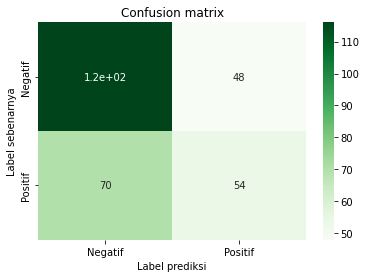

In [38]:
from time import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pandas import DataFrame

t = time()
y_pred = model.predict(x_tes)

test_time = time() - t
print("test time:  %0.3fs" % test_time)

score1 = metrics.accuracy_score(y_tes, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_tes, y_pred, target_names=['Negatif', 'Positif']))

columns = ['Negatif', 'Positif']
confm = confusion_matrix(y_tes, y_pred)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Greens', annot=True)
ax.set_title('Confusion matrix')
ax.set_xlabel('Label prediksi')
ax.set_ylabel('Label sebenarnya')

In [39]:
user_data = ["keren prabowo menang oleh suara sultra calon"]
print(user_data)

['keren prabowo menang oleh suara sultra calon']


In [40]:
test_1_unseen =  bow_transformer.transform(user_data)
data=test_1_unseen.toarray()
print("diubah menjadi array: \n ",data)

diubah menjadi array: 
  [[0 0 0 ... 0 0 0]]


In [41]:
prediction_unseen = model.predict(data)
print(prediction_unseen)

['Positif']


In [42]:
import csv
with open('prediksi-langsung.csv', 'a+', newline='') as file:
    writer = csv.writer(file)
    #writer.writerow(dataset)
    writer.writerow([user_data,prediction_unseen])

### Klasifikasi menggunakan LSTM

In [43]:
newDataLSTM = pd.read_csv('Data-hasil-stemming.csv',encoding='ISO-8859-1')

In [44]:
df = df[(newDataLSTM["text"].notna()) & (newDataLSTM["text"] != "")]

# use 80% of the data for training, and set aside 20% for testing
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(index=train_df.index)

In [45]:
train_df.klasifikasi.value_counts()

Negatif    598
Positif    401
Name: klasifikasi, dtype: int64

In [46]:
# further split the training set into training and validation set
X = train_df.text
y = train_df.klasifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
nunique_words = len(tokenizer.word_index) + 1
print("Number of Unique Words: {}".format(nunique_words))

Number of Unique Words: 4482


In [48]:
# saving tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train))
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=X_train.shape[1])
y_train = y_train.replace({"Negatif": 0, "Positif": 1})
y_test = y_test.replace({"Negatif": 0, "Positif": 1})

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=nunique_words, output_dim=128),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [51]:
mc_callback = ModelCheckpoint(
    filepath="lstm_model-{epoch:02d}.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[mc_callback],
    batch_size=128,
    verbose=2)

Epoch 1/100
7/7 - 10s - loss: 0.6844 - accuracy: 0.5972 - val_loss: 0.6822 - val_accuracy: 0.5533 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 0.6679 - accuracy: 0.6066 - val_loss: 0.6789 - val_accuracy: 0.5533 - 1s/epoch - 188ms/step
Epoch 3/100
7/7 - 1s - loss: 0.6367 - accuracy: 0.6066 - val_loss: 0.6559 - val_accuracy: 0.6267 - 1s/epoch - 188ms/step
Epoch 4/100
7/7 - 1s - loss: 0.5700 - accuracy: 0.7892 - val_loss: 0.6635 - val_accuracy: 0.6133 - 1s/epoch - 159ms/step
Epoch 5/100
7/7 - 1s - loss: 0.4101 - accuracy: 0.8492 - val_loss: 0.8088 - val_accuracy: 0.6067 - 1s/epoch - 177ms/step
Epoch 6/100
7/7 - 2s - loss: 0.1723 - accuracy: 0.9505 - val_loss: 1.0791 - val_accuracy: 0.6133 - 2s/epoch - 261ms/step
Epoch 7/100
7/7 - 1s - loss: 0.0779 - accuracy: 0.9776 - val_loss: 1.4597 - val_accuracy: 0.5933 - 1s/epoch - 189ms/step
Epoch 8/100
7/7 - 1s - loss: 0.0402 - accuracy: 0.9894 - val_loss: 1.6790 - val_accuracy: 0.6267 - 928ms/epoch - 133ms/step
Epoch 9/100
7/7 - 1s - loss: 0

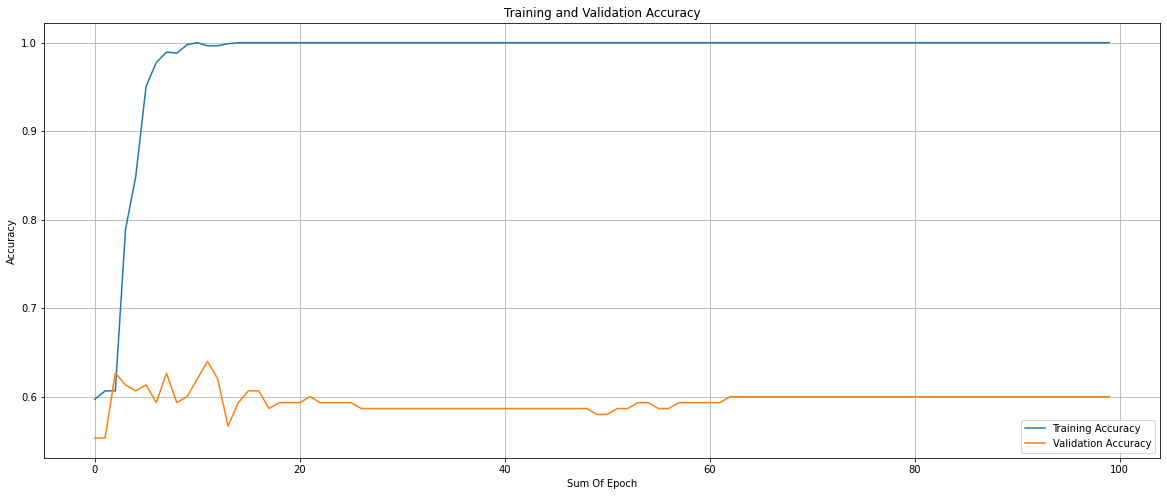

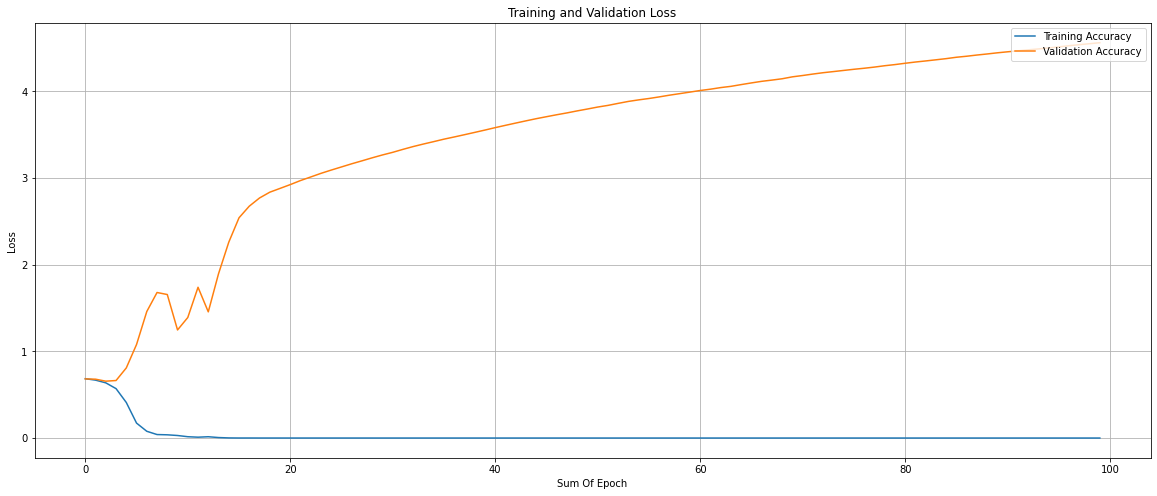

In [52]:
# Plot Training & Validation Accuracy Values
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot Training & Validation Loss Values
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()

### Evaluation on test data

In [53]:
# Evaluate
evaluate = model.evaluate(X_test, y_test, verbose=1)
print('Loss: ', evaluate[0])
print('Accuracy: ', evaluate[1]*100, ' %')

5/5 [==============================] - 0s 7ms/step - loss: 4.5612 - accuracy: 0.6000
Loss:  4.561166763305664
Accuracy:  60.00000238418579  %


In [75]:
model.save('twitter-sentiment-analysis-model-lstm.h5')

In [76]:
newmodel = load_model("twitter-sentiment-analysis-model-lstm.h5")

In [77]:
with open("/content/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

In [78]:
sequences = pad_sequences(
    tokenizer.texts_to_sequences(newDataLSTM["text"]), maxlen=X_train.shape[1]
)
score = newmodel.predict(sequences)
newDataLSTM["score"] = score
newDataLSTM["pred_klasifikasi"] = newDataLSTM["score"].apply(
    lambda x: "Positif" if x >= 0.50 else "Negatif"
)

40/40 [==============================] - 1s 3ms/step


In [79]:
accuracy_score(newDataLSTM["klasifikasi"], newDataLSTM["pred_klasifikasi"])

0.7814251401120896

In [80]:
tn, fp, fn, tp = confusion_matrix(
    newDataLSTM["klasifikasi"], newDataLSTM["pred_klasifikasi"]
).ravel()
tnr = tn / (tn + fp)
tpr = tp / (tp + fn)
print("True Negative Rate: {:.3f}".format(tnr))
print("True Positive Rate: {:.3f}".format(tpr))

True Negative Rate: 0.876
True Positive Rate: 0.641
